In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Load Cifar10

In [2]:
from tensorflow.python.keras.datasets import cifar10
from skimage import io, color

def loadCifar10():
    (train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
    train_images, test_images = train_images.astype(float), test_images.astype(float)
    train_images /= 255.
    test_images /= 255.
    
    train_lab = np.array([color.rgb2lab(rgb) for rgb in train_images]).astype(float)
    test_lab = np.array([color.rgb2lab(rgb) for rgb in test_images]).astype(float)
    
    train_lab += np.array([0, 100, 100])
    train_lab /= np.array([100, 200, 200])
    test_lab += np.array([0, 100, 100])
    test_lab /= np.array([100, 200, 200])
    
    class_dict = {0 : "airplane",
                  1 : "automobile",
                  2 : "bird",
                  3 : "cat",
                  4 : "deer",
                  5 : "dog",
                  6 : "frog",
                  7 : "horse",
                  8 : "ship",
                  9 : "truck"}
    
    return train_images, train_lab, train_labels, test_images, test_lab, test_labels, class_dict, 256, 10

# Preprocess

In [3]:
train_images, train_lab, train_labels, test_images, test_lab, test_labels, class_dict, batch_size, n_classes = loadCifar10()

In [4]:
from tensorflow.python.keras.utils import to_categorical

#Images
weights = np.array([0.2125, 0.7154, 0.0721])
train_grays = np.sum(weights * train_images, axis = -1)
test_grays = np.sum(weights * test_images, axis = -1)
#train_grays = weights[0] * train_images[:, :, :, 0] + weights[1] * train_images[:, :, :, 1] + weights[2] * train_images[:, :, :, 2]
#test_grays = weights[0] * test_images[:, :, :, 0] + weights[1] * test_images[:, :, :, 1] + weights[2] * test_images[:, :, :, 2]
train_grays = np.expand_dims(train_grays, -1)
test_grays = np.expand_dims(test_grays, -1)

w, h = train_grays.shape[1], train_grays.shape[2]

#Classes
train_labels, test_labels = to_categorical(train_labels), to_categorical(test_labels)

(50000, 32, 32, 1) (50000, 32, 32, 3)
0.0 1.0 -0.03928650103347444 1.0 0.0 1.0
(10000, 32, 32, 1) (10000, 32, 32, 3)
0.0 1.0 -0.013611292779800409 1.0 0.0 1.0


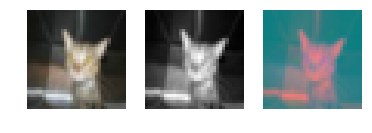

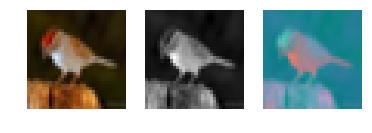

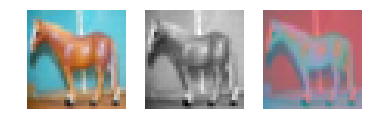

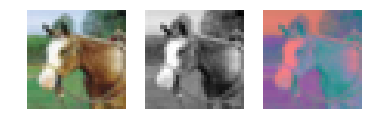

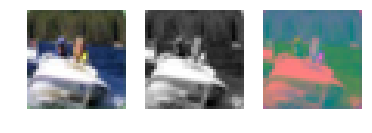

In [5]:
print(train_grays.shape, train_images.shape)
print(np.min(train_grays), np.max(train_grays), np.min(train_lab), np.max(train_lab), np.min(train_images), np.max(train_images))
print(test_grays.shape, test_images.shape)
print(np.min(test_grays), np.max(test_grays), np.min(test_lab), np.max(test_lab), np.min(test_images), np.max(test_images))

for i in range(5):
    ind = np.random.randint(len(test_images))
    plt.subplot(131)
    plt.imshow(test_images[ind])
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(test_grays[ind, :, :, 0], cmap = "gray")
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(test_lab[ind])
    plt.axis('off')
    plt.show()

# Learning

In [6]:
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, AveragePooling2D
from tensorflow.python.keras.layers import Concatenate, BatchNormalization, RepeatVector, Flatten, Dense, Reshape

def lowLevelFeatureNetwork(w, h):
    features = Input((w, h, 1), name = "input_features")
    
    conv00 = BatchNormalization()(Conv2D(8, (3, 3), activation='relu', padding = "same")(features))
    conv01 = BatchNormalization()(Conv2D(16, (3, 3), activation='relu', padding = "same")(conv00))
    pool0 = MaxPooling2D((2, 2))(conv01)
    
    conv10 = BatchNormalization()(Conv2D(16, (3, 3), activation='relu', padding = "same")(pool0))
    conv11 = BatchNormalization()(Conv2D(32, (3, 3), activation='relu', padding = "same")(conv10))
    pool1 = MaxPooling2D((2, 2))(conv11)
    
    conv20 = BatchNormalization()(Conv2D(32, (3, 3), activation='relu', padding = "same")(pool1))
    conv21 = BatchNormalization()(Conv2D(64, (3, 3), activation='relu', padding = "same")(conv20))
    
    return Model(inputs = features, outputs = conv21, name = "lowLevelFeature")

def midLevelFeatureNetwork(w_, h_):
    features = Input((w_, h_, 64), name = "input_features")
    
    conv00 = BatchNormalization()(Conv2D(128, (3, 3), activation='relu', padding = "same")(features))
    conv01 = BatchNormalization()(Conv2D(64, (3, 3), activation='relu', padding = "same")(conv00))
    
    return Model(inputs = features, outputs = conv01, name = "midLevelFeature")

def colorizationNetwork(w_, h_):
    features = Input((w_, h_, 128), name = "input_features")
    
    conv00 = BatchNormalization()(Conv2D(128, (3, 3), activation='relu', padding = "same")(features))
    conv01 = BatchNormalization()(Conv2D(64, (3, 3), activation='relu', padding = "same")(conv00))
    up0 = UpSampling2D((2, 2))(conv01)
    
    conv10 = BatchNormalization()(Conv2D(64, (3, 3), activation='relu', padding = "same")(up0))
    conv11 = BatchNormalization()(Conv2D(32, (3, 3), activation='relu', padding = "same")(conv10))
    up1 = UpSampling2D((2, 2))(conv11)
    
    conv20 = BatchNormalization()(Conv2D(32, (3, 3), activation='relu', padding = "same")(up1))
    conv21 = BatchNormalization()(Conv2D(16, (3, 3), activation='relu', padding = "same")(conv20))
    
    return Model(inputs = features, outputs = conv21, name = "colorization")

def globalFeatureNetwork(w_, h_):
    features = Input((w_, h_, 64), name = "input_features")
    
    pool0 = MaxPooling2D((2, 2))(features)
    
    conv00 = BatchNormalization()(Conv2D(64, (3, 3), activation='relu', padding = "same")(pool0))
    conv01 = BatchNormalization()(Conv2D(128, (3, 3), activation='relu', padding = "same")(conv00))
    pool1 = MaxPooling2D((2, 2))(conv01)
    
    conv10 = BatchNormalization()(Conv2D(128, (3, 3), activation='relu', padding = "same")(pool1))
    conv11 = BatchNormalization()(Conv2D(256, (3, 3), activation='relu', padding = "same")(conv10))
    
    flatten = Flatten()(conv11)

    dense0 = BatchNormalization()(Dense(256, activation = "relu")(flatten))
    dense1 = BatchNormalization()(Dense(128, activation = "relu")(dense0))
    dense2 = BatchNormalization()(Dense(64, activation = "relu")(dense1))
    
    return Model(inputs = features, outputs = dense2, name = "globalFeature")

def classificationNetwork(n_classes):
    features = Input((64, ), name = "input_features")
    
    dense0 = BatchNormalization()(Dense(32, activation = "relu")(features))
    dense1 = Dense(n_classes, activation = "softmax")(dense0)
    
    return Model(inputs = features, outputs = dense1, name = "classification")

def build_model(w, h, n_classes):
    n_pool = 2
    w_, h_ = w // (2**n_pool), h // (2**n_pool)
    
    features = Input((w, h, 1), name = "gray_image")
    
    lowLevelFeatures = lowLevelFeatureNetwork(w, h)(features)
    midLevelFeatures = midLevelFeatureNetwork(w_, h_)(lowLevelFeatures)
    
    globalFeatures = globalFeatureNetwork(w_, h_)(lowLevelFeatures)
    
    #Colorization
    chrominance = colorizationNetwork(w_, h_)(Concatenate()([midLevelFeatures,
                                                       Reshape((w_, h_, -1))(RepeatVector(w_ * h_)(globalFeatures))]))
    
    concat = Concatenate()([chrominance, features])
    temp = Conv2D(8, (3, 3), activation='relu', padding = "same")(concat)
    recolored = Conv2D(3, (3, 3), activation='sigmoid', padding = "same", name = "recolor")(temp)
    
    #Classification
    classified = classificationNetwork(n_classes)(globalFeatures)
    
    #Model
    model = Model(inputs = features, outputs = [recolored, classified])
    
    losses = {"recolor" : "mean_squared_error", "classification" : "categorical_crossentropy"}
    lossWeights = {"recolor": .25, "classification": 1.0}

    model.compile(optimizer='adadelta', loss = losses, loss_weights = lossWeights, metrics = ["accuracy"])
    
    return model

model = build_model(w, h, n_classes)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gray_image (InputLayer)         (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
lowLevelFeature (Model)         (None, 8, 8, 64)     36624       gray_image[0][0]                 
__________________________________________________________________________________________________
globalFeature (Model)           (None, 64)           861184      lowLevelFeature[1][0]            
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 64, 64)       0           globalFeature[1][0]              
__________________________________________________________________________________________________
midLevelFe

In [7]:
nepochs = 25
history = model.fit(train_grays, {"recolor" : train_lab, "classification" : train_labels},
                    epochs=nepochs, batch_size=batch_size,
                    validation_data = (test_grays, {"recolor" : test_lab, "classification" : test_labels}))
history_dict = history.history

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 40s 795us/step - loss: 1.7143 - recolor_loss: 0.0212 - classification_loss: 1.7090 - recolor_acc: 0.5181 - classification_acc: 0.3929 - val_loss: 3.2466 - val_recolor_loss: 0.0126 - val_classification_loss: 3.2434 - val_recolor_acc: 0.6121 - val_classification_acc: 0.1000
Epoch 2/25
50000/50000 [==============================] - 31s 625us/step - loss: 1.2703 - recolor_loss: 0.0085 - classification_loss: 1.2681 - recolor_acc: 0.6514 - classification_acc: 0.5533 - val_loss: 3.3719 - val_recolor_loss: 0.0109 - val_classification_loss: 3.3692 - val_recolor_acc: 0.6029 - val_classification_acc: 0.1937
Epoch 3/25
50000/50000 [==============================] - 31s 618us/step - loss: 1.0324 - recolor_loss: 0.0061 - classification_loss: 1.0309 - recolor_acc: 0.6870 - classification_acc: 0.6419 - val_loss: 1.3635 - val_recolor_loss: 0.0069 - val_classification_loss: 1.3618 - val_recolor_ac

50000/50000 [==============================] - 31s 612us/step - loss: 0.0902 - recolor_loss: 0.0036 - classification_loss: 0.0893 - recolor_acc: 0.7396 - classification_acc: 0.9701 - val_loss: 1.3981 - val_recolor_loss: 0.0037 - val_classification_loss: 1.3971 - val_recolor_acc: 0.7350 - val_classification_acc: 0.7108


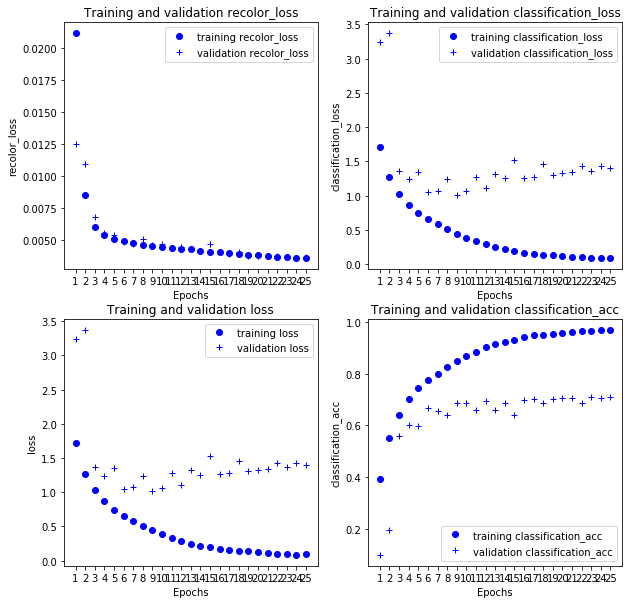

In [8]:
plt.figure(figsize = (10, 10))

for i, metric in enumerate(["recolor_loss", "classification_loss", "loss", "classification_acc"]):
    values = history_dict[metric]
    val_values = history_dict['val_' + metric]
    epochs = range(1, len(values) + 1)
    
    plt.subplot(221 + i)
    plt.plot(epochs, values, 'bo', label = 'training ' + metric)
    plt.plot(epochs, val_values, 'b+', label = 'validation ' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.xticks(1 + np.arange(nepochs))
    plt.legend(loc = 'best')
    plt.title('Training and validation ' + metric)
plt.show()

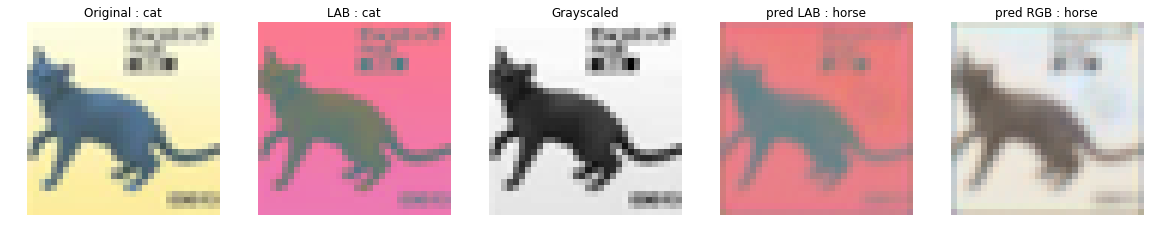

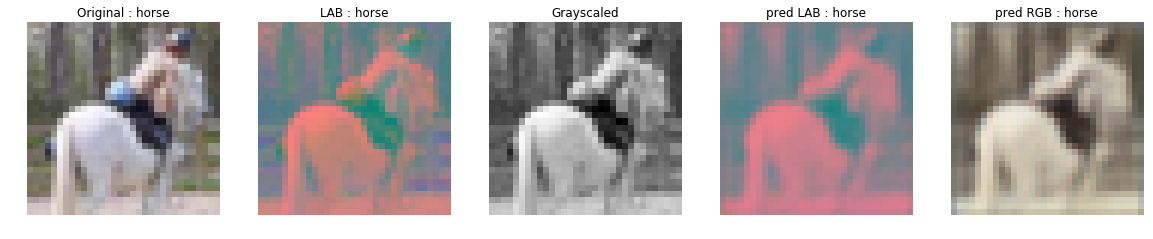

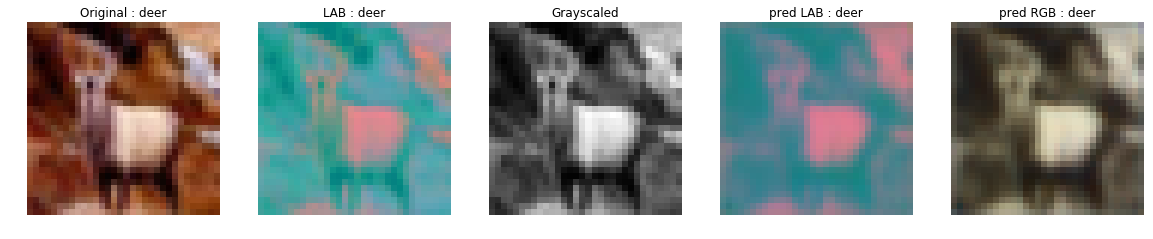

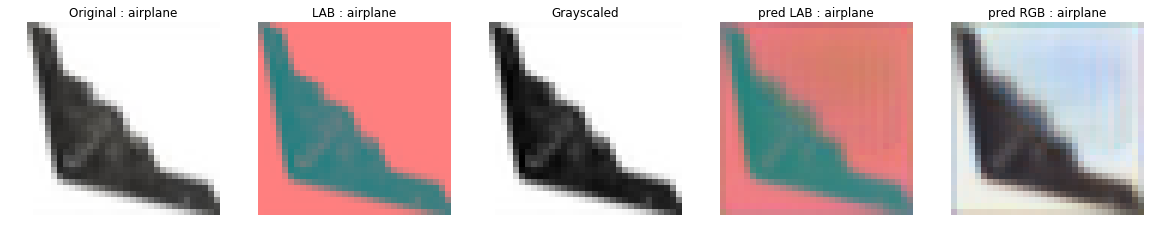

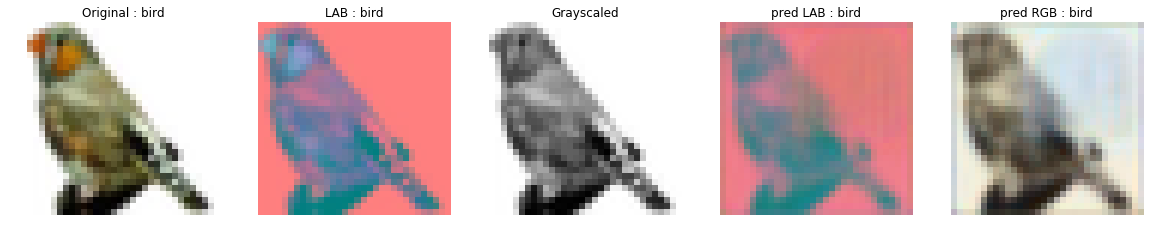

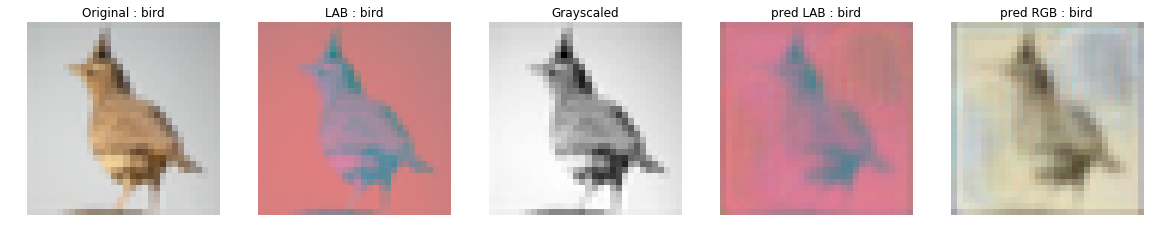

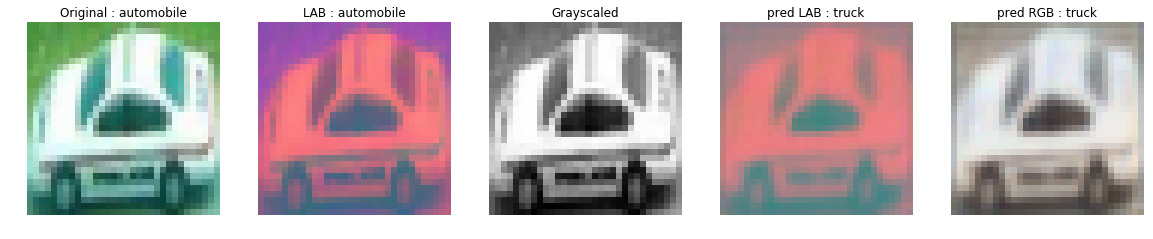

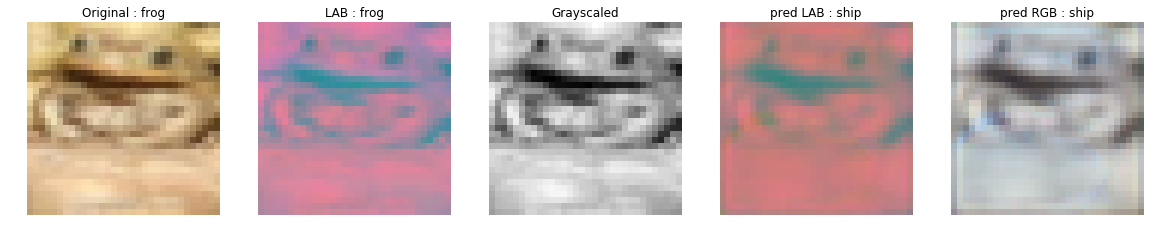

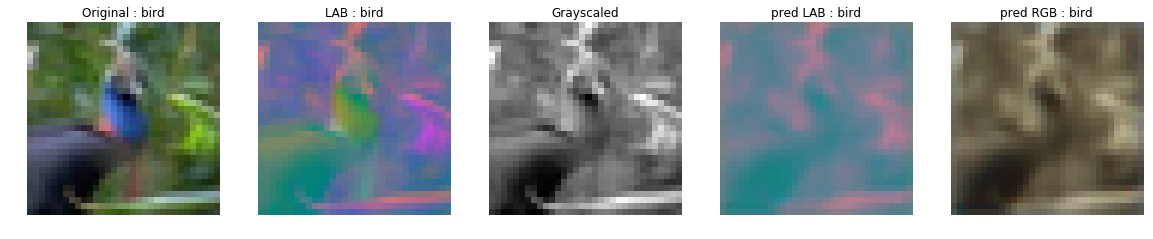

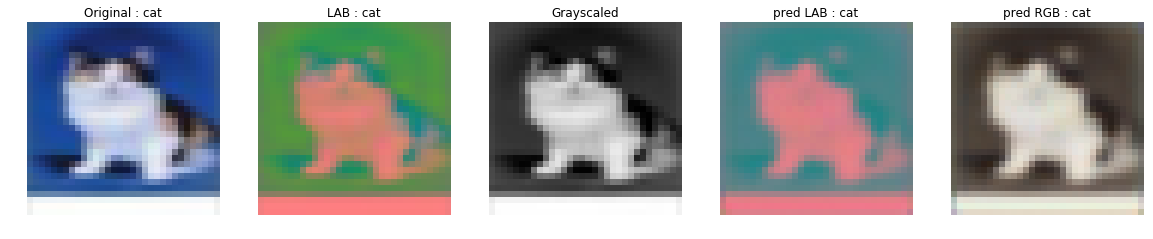

In [9]:
test_recolored_lab, test_preds = model.predict(test_grays)
test_recolored_rgb = np.array([color.lab2rgb(np.array([100, 200, 200]) * lab - np.array([0, 100, 100]))
                               for lab in test_recolored_lab])

for i in range(10):
    ind = np.random.randint(len(test_images))
    plt.figure(figsize = (20, 4))
    plt.subplot(151)
    plt.imshow(test_images[ind])
    plt.title("Original : " + class_dict[np.argmax(test_labels[ind])])
    plt.axis('off')
    plt.subplot(152)
    plt.imshow(test_lab[ind])
    plt.title("LAB : " + class_dict[np.argmax(test_labels[ind])])
    plt.axis('off')
    plt.subplot(153)
    plt.imshow(test_grays[ind, :, :, 0], cmap = "gray")
    plt.title("Grayscaled")
    plt.axis('off')
    plt.subplot(154)
    plt.imshow(test_recolored_lab[ind])
    plt.title("pred LAB : " + class_dict[np.argmax(test_preds[ind])])
    plt.axis('off')
    plt.subplot(155)
    plt.imshow(test_recolored_rgb[ind])
    plt.title("pred RGB : " + class_dict[np.argmax(test_preds[ind])])
    plt.axis('off')
    plt.show()